In [1]:
import gerrychain


In [2]:
from gerrychain import Graph, Partition
from gerrychain.updaters import Tally, cut_edges


# Load the graph in from the provided json file
graph = Graph.from_json("./PA_VTDs.json")

# Set up the initial partition object
initial_partition = Partition(
    graph,
    assignment="2011_PLA_1",
    updaters={
        "population": Tally("TOT_POP", alias="population"),
        "cut_edges": cut_edges,
    }
)

In [3]:
for district, pop in initial_partition["population"].items():
    print(f"District {district}: {pop}")

District 3: 706653
District 10: 706992
District 9: 702500
District 5: 695917
District 15: 705549
District 6: 705782
District 11: 705115
District 8: 705689
District 4: 705669
District 18: 705847
District 12: 706232
District 17: 699133
District 7: 712463
District 16: 699557
District 14: 705526
District 13: 705028
District 2: 705689
District 1: 705588


In [4]:
from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept

chain = MarkovChain(
    proposal=propose_random_flip,
    constraints=[single_flip_contiguous],
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

In [5]:
i = 1
for partition in chain:
    print(f"Step {i} population for district 1: {partition['population'][1]}")
    i += 1

Step 1 population for district 1: 705588
Step 2 population for district 1: 705588
Step 3 population for district 1: 705588
Step 4 population for district 1: 705588
Step 5 population for district 1: 705588
Step 6 population for district 1: 705588
Step 7 population for district 1: 705588
Step 8 population for district 1: 705588
Step 9 population for district 1: 705588
Step 10 population for district 1: 705588
Step 11 population for district 1: 705588
Step 12 population for district 1: 705588
Step 13 population for district 1: 705588
Step 14 population for district 1: 705588
Step 15 population for district 1: 705588
Step 16 population for district 1: 705588
Step 17 population for district 1: 705588
Step 18 population for district 1: 705588
Step 19 population for district 1: 705588
Step 20 population for district 1: 705588
Step 21 population for district 1: 705588
Step 22 population for district 1: 705588
Step 23 population for district 1: 705588
Step 24 population for district 1: 705588
S

In [6]:
from gerrychain import Election

# Set up the election updater. We give the election a name ("SEN12") and tell it
# which column in our shapefile holds the Democratic vote totals ("USS12D")
# and which column holds the Republican vote totals ("USS12R").
election = Election("SEN12", {"Dem": "USS12D", "Rep": "USS12R"})

initial_partition_2 = Partition(
    graph,
    assignment="2011_PLA_1",
    updaters={
        "population": Tally("TOT_POP", alias="population"),
        "cut_edges": cut_edges,
        "SEN12": election
    }
)

In [7]:
from gerrychain.constraints import contiguous

chain_2 = MarkovChain(
    proposal=propose_random_flip,
    constraints=[contiguous],
    accept=always_accept,
    initial_state=initial_partition_2,
    total_steps=1000
)

for (i, partition) in enumerate(chain_2):
    print(f"Step {i} Democratic vote share for district 1: "
          f"{partition['SEN12'].percents('Dem')[1]:0.4f}")

Step 0 Democratic vote share for district 1: 0.4110
Step 1 Democratic vote share for district 1: 0.4110
Step 2 Democratic vote share for district 1: 0.4110
Step 3 Democratic vote share for district 1: 0.4110
Step 4 Democratic vote share for district 1: 0.4110
Step 5 Democratic vote share for district 1: 0.4110
Step 6 Democratic vote share for district 1: 0.4110
Step 7 Democratic vote share for district 1: 0.4110
Step 8 Democratic vote share for district 1: 0.4110
Step 9 Democratic vote share for district 1: 0.4110
Step 10 Democratic vote share for district 1: 0.4110
Step 11 Democratic vote share for district 1: 0.4110
Step 12 Democratic vote share for district 1: 0.4109
Step 13 Democratic vote share for district 1: 0.4109
Step 14 Democratic vote share for district 1: 0.4109
Step 15 Democratic vote share for district 1: 0.4109
Step 16 Democratic vote share for district 1: 0.4108
Step 17 Democratic vote share for district 1: 0.4108
Step 18 Democratic vote share for district 1: 0.4106
Ste

In [8]:
import pandas

d_percents = []
for partition in chain_2:
    # We use the sorted function here to ensure that the data is in the same order
    # as the districts assignments
    d_percents.append(sorted(partition["SEN12"].percents("Dem")))

data = pandas.DataFrame(d_percents)

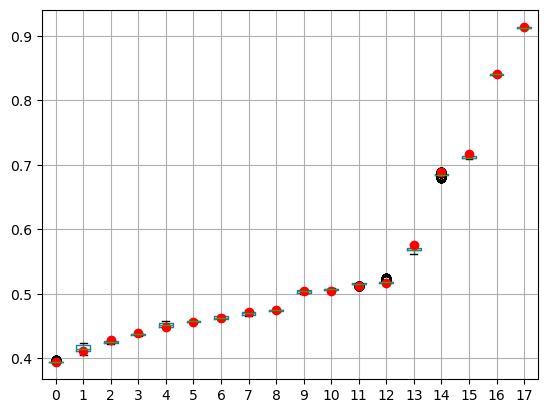

In [9]:
import matplotlib.pyplot as plt

ax = data.boxplot(positions=range(len(data.columns)))
plt.plot(data.iloc[0], "ro")

plt.show()

In [10]:
import matplotlib.pyplot as plt
from gerrychain import (Partition, Graph, MarkovChain,
                        updaters, constraints, accept)
from gerrychain.proposals import recom
from gerrychain.constraints import contiguous
from functools import partial
import pandas

# Set the random seed so that the results are reproducible!
import random
random.seed(2024)

In [11]:
#graph = Graph.from_json("./gerrymandria.json")
graph = Graph.from_json("new_graph.json")
my_updaters = {
    "population": updaters.Tally("TOTPOP"),
    "cut_edges": updaters.cut_edges
}

initial_partition = Partition(
     graph,
     assignment="district",
     updaters=my_updaters
 )

In [12]:
# This should be 8 since each district has 1 person in it.
# Note that the key "population" corresponds to the population updater
# that we defined above and not with the population column in the json file.
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

proposal = partial(
    recom,
    pop_col="TOTPOP",
    pop_target=ideal_population,
    #initial value
    #epsilon=0.01,
    epsilon=0.1,
    node_repeats=2
)

In [13]:
recom_chain = MarkovChain(
    proposal=proposal,
    constraints=[contiguous],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=40
)

In [14]:
assignment_list = []

for i, item in enumerate(recom_chain):
    print(f"Finished step {i+1}/{len(recom_chain)}", end="\r")
    assignment_list.append(item.assignment)

In [22]:
import csv

with open("partitions.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["partition", "node", "district"])  # header

    for partition_num, assignment in enumerate(assignment_list):
        for node, district in assignment.items():
            writer.writerow([partition_num, node, district])

In [21]:
i = 0
for state in assignment_list:
    print(state)
    i = i + 1
print(i)

<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignment [16 keys, 4 parts]>
<Assignm

In [16]:
%matplotlib inline
import matplotlib_inline.backend_inline
import matplotlib.cm as mcm
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image
import io
#import ipywidgets as widgets
from IPython.display import display, clear_output
import os

frames = []

for i in range(len(assignment_list)):
    fig, ax = plt.subplots(figsize=(8,8))
    pos = {node :(data['x'],data['y']) for node, data in graph.nodes(data=True)}
    node_colors = [mcm.tab20(int(assignment_list[i][node]) % 20) for node in graph.nodes()]
    node_labels = {node: str(assignment_list[i][node]) for node in graph.nodes()}

    nx.draw_networkx_nodes(graph, pos, node_color=node_colors)
    nx.draw_networkx_edges(graph, pos)
    nx.draw_networkx_labels(graph, pos, labels=node_labels)
    plt.axis('off')

    buffer = io.BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    image = Image.open(buffer)
    #saving image to some file
    #ok so for the time being it just saves to whatever folder this is being run in
    #image.save("gerryman" + str(i) + ".png")
    frames.append(image)
    plt.close(fig)

def show_frame(idx):
    clear_output(wait=True)
    display(frames[idx])

#slider = widgets.IntSlider(value=0, min=0, max=len(frames)-1, step=1, description='Frame:')
#slider.layout.width = '500px'
#widgets.interactive(show_frame, idx=slider)

In [20]:
print(list(graph.nodes(data=True)))
for x in graph.nodes(data=True):
    print(x)


[(0, {'district': '0', 'TOTPOP': 32.0, 'x': 0, 'y': 0}), (1, {'district': '1', 'TOTPOP': 26.0, 'x': 1, 'y': 0}), (2, {'district': '2', 'TOTPOP': 34.0, 'x': 2, 'y': 0}), (3, {'district': '3', 'TOTPOP': 29.0, 'x': 3, 'y': 0}), (4, {'district': '0', 'TOTPOP': 24.0, 'x': 0, 'y': 1}), (5, {'district': '1', 'TOTPOP': 28.0, 'x': 1, 'y': 1}), (6, {'district': '2', 'TOTPOP': 26.0, 'x': 2, 'y': 1}), (7, {'district': '3', 'TOTPOP': 22.0, 'x': 3, 'y': 1}), (8, {'district': '0', 'TOTPOP': 23.0, 'x': 0, 'y': 2}), (9, {'district': '1', 'TOTPOP': 26.0, 'x': 1, 'y': 2}), (10, {'district': '2', 'TOTPOP': 29.0, 'x': 2, 'y': 2}), (11, {'district': '3', 'TOTPOP': 26.0, 'x': 3, 'y': 2}), (12, {'district': '0', 'TOTPOP': 28.0, 'x': 0, 'y': 3}), (13, {'district': '1', 'TOTPOP': 31.0, 'x': 1, 'y': 3}), (14, {'district': '2', 'TOTPOP': 31.0, 'x': 2, 'y': 3}), (15, {'district': '3', 'TOTPOP': 25.0, 'x': 3, 'y': 3})]
(0, {'district': '0', 'TOTPOP': 32.0, 'x': 0, 'y': 0})
(1, {'district': '1', 'TOTPOP': 26.0, 'x':